#### Imports 

In [81]:
import dateutil.parser as dt_parser
import pandas as pd
import boto3
import time
import json
import sys
import os

#### 1. Essentials 

In [9]:
DATASET_FREQUENCY = 'H'
TIMESTAMP_FORMAT = 'yyyy-MM-dd hh:mm:ss'
BUCKET = 'forecast-demo-892313895307'
REGION = 'us-east-1'

session = boto3.Session(region_name=REGION) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

#### 2. Prep & Explore Data

In [37]:
df = pd.read_csv('./DATA/train.csv', dtype=object, names=['timestamp', 'value', 'item'])
df.head(3)

,timestamp,value,item
0,2014-01-01 01:00:00,38.34991708126038,client_12
1,2014-01-01 02:00:00,33.5820895522388,client_12
2,2014-01-01 03:00:00,34.41127694859037,client_12


Notice in the output above there are 3 columns of data:

a. Timestamp <br> b. Value <br> c. Item <br> <br>
These are the 3 key required pieces of information to generate a forecast with Amazon Forecast. <br>
More can be added but these 3 must always remain present.

#### 3. Upload Data to S3

In [4]:
key = 'train.csv'
session.resource('s3').Bucket(BUCKET).Object(key).upload_file('./DATA/train.csv')

#### 4. Create Dataset Group

In [5]:
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName='forecast_demo_dataset_group',
                                                              Domain='CUSTOM',
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']
datasetGroupArn

'arn:aws:forecast:us-east-1:892313895307:dataset-group/forecast_demo_dataset_group'

#### 5. Create Schema & Dataset

In [7]:
schema = {
   "Attributes": [
      {
         "AttributeName": "timestamp",
         "AttributeType": "timestamp"
      },
      {
         "AttributeName": "target_value",
         "AttributeType": "float"
      },
      {
         "AttributeName": "item_id",
         "AttributeType": "string"
      }
   ]
}

In [11]:
response=forecast.create_dataset(
                    Domain='CUSTOM',
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName='forecast_demo_dataset',
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

In [38]:
datasetArn = response['DatasetArn']
datasetArn

'arn:aws:forecast:us-east-1:892313895307:dataset/forecast_demo_dataset'

#### 6. Add Dataset to Dataset Group

In [13]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

{'ResponseMetadata': {'RequestId': '7db3ab51-94c0-4993-a15a-600efc8a300d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 15 Oct 2020 20:01:07 GMT',
   'x-amzn-requestid': '7db3ab51-94c0-4993-a15a-600efc8a300d',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

#### 7. Create Data Import Job

In [16]:
datasetImportJobName = 'FORECAST_DEMO_DATA_IMPORT'
ds_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName, 
                                                            DatasetArn=datasetArn,
                                                            DataSource={
                                                                "S3Config" : {
                                                                "Path": "s3://forecast-demo-892313895307/train.csv",
                                                                "RoleArn": "arn:aws:iam::892313895307:role/service-role/AmazonForecast-ExecutionRole-1590117655708"
                                                                } 
                                                            }, 
                                                            TimestampFormat=TIMESTAMP_FORMAT)

In [18]:
ds_import_job_arn = ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:892313895307:dataset-import-job/forecast_demo_dataset/FORECAST_DEMO_DATA_IMPORT


In [20]:
status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
status

'ACTIVE'

In [21]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'DatasetImportJobName': 'FORECAST_DEMO_DATA_IMPORT',
 'DatasetImportJobArn': 'arn:aws:forecast:us-east-1:892313895307:dataset-import-job/forecast_demo_dataset/FORECAST_DEMO_DATA_IMPORT',
 'DatasetArn': 'arn:aws:forecast:us-east-1:892313895307:dataset/forecast_demo_dataset',
 'TimestampFormat': 'yyyy-MM-dd hh:mm:ss',
 'DataSource': {'S3Config': {'Path': 's3://forecast-demo-892313895307/train.csv',
   'RoleArn': 'arn:aws:iam::892313895307:role/service-role/AmazonForecast-ExecutionRole-1590117655708'}},
 'FieldStatistics': {'item_id': {'Count': 21885,
   'CountDistinct': 3,
   'CountNull': 0},
  'target_value': {'Count': 21885,
   'CountDistinct': 4635,
   'CountNull': 0,
   'CountNan': 0,
   'Min': '0.0',
   'Max': '209.99170812603649',
   'Avg': 50.09474329868638,
   'Stddev': 38.47197571594978},
  'timestamp': {'Count': 21885,
   'CountDistinct': 7295,
   'CountNull': 0,
   'Min': '2014-01-01T01:00:00Z',
   'Max': '2014-10-31T23:00:00Z'}},
 'DataSize': 0.0009746281430125237,
 'Status'

#### 8. Create a Predictor (Model Training Step)

Forecast horizon is the number of number of time points to predicted in the future. For weekly data, a value of 12 means 12 weeks. Our example is hourly data, we try forecast the next day, so we can set to 24.

In [23]:
algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'
forecastHorizon = 24

In [25]:
create_predictor_response = forecast.create_predictor(
                                                PredictorName='DeepAR_Demo', 
                                                AlgorithmArn=algorithmArn,
                                                ForecastHorizon=forecastHorizon,
                                                PerformAutoML= False,
                                                PerformHPO=False,
                                                EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                     "BackTestWindowOffset": 24}, 
                                                InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                FeaturizationConfig= {"ForecastFrequency": "H", 
                                                                    "Featurizations": 
                                                                    [
                                                                      {"AttributeName": "target_value", 
                                                                       "FeaturizationPipeline": 
                                                                        [
                                                                          {"FeaturizationMethodName": "filling", 
                                                                           "FeaturizationMethodParameters": 
                                                                            {"frontfill": "none", 
                                                                             "middlefill": "zero", 
                                                                             "backfill": "zero"}
                                                                          }
                                                                        ]
                                                                      }
                                                                    ]
                                                                   })

In [26]:
create_predictor_response

{'PredictorArn': 'arn:aws:forecast:us-east-1:892313895307:predictor/DeepAR_Demo',
 'ResponseMetadata': {'RequestId': 'e5fa1165-57d7-4ec7-9ac9-5d68473cdd18',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 15 Oct 2020 20:35:38 GMT',
   'x-amzn-requestid': 'e5fa1165-57d7-4ec7-9ac9-5d68473cdd18',
   'content-length': '80',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [28]:
predictor_arn = create_predictor_response['PredictorArn']
predictor_arn

'arn:aws:forecast:us-east-1:892313895307:predictor/DeepAR_Demo'

In [44]:
status = forecast.describe_predictor(PredictorArn=predictor_arn)['Status']
status

'ACTIVE'

#### Get Error Metrics 

In [45]:
forecast.get_accuracy_metrics(PredictorArn=predictor_arn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 19.542885831168935,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.09109362998309353},
       {'Quantile': 0.5, 'LossValue': 0.26745366761597034},
       {'Quantile': 0.1, 'LossValue': 0.20455233693856245}]}},
    {'TestWindowStart': datetime.datetime(2014, 10, 31, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2014, 11, 1, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 3,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 19.542885831168935,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.09109362998309353},
       {'Quantile': 0.5, 'LossValue': 0.26745366761597034},
       {'Quantile': 0.1, 'LossValue': 0.20455233693856245}]}}]}],
 'ResponseMetadata': {'RequestId': '3dd0d6db-cbf5-4888-bb1f-e3721245ae93',
  'HTTPStatusCode': 200,
  'HTTPHeaders'

#### 9. Host the Model for Inference 

In [50]:
forecast_name = 'forecast_deep_ar'

In [51]:
create_forecast_response = forecast.create_forecast(ForecastName=forecast_name, 
                                                    PredictorArn=predictor_arn)
forecast_arn = create_forecast_response['ForecastArn']

In [58]:
status = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
status

'ACTIVE'

#### 10. Test Inference

In [61]:
print(forecast_arn)
print()
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id": "client_12"}
)
print(json.dumps(forecastResponse, indent=4))

arn:aws:forecast:us-east-1:892313895307:forecast/forecast_deep_ar

{
    "Forecast": {
        "Predictions": {
            "p10": [
                {
                    "Timestamp": "2014-11-01T00:00:00",
                    "Value": 38.10956954956055
                },
                {
                    "Timestamp": "2014-11-01T01:00:00",
                    "Value": 32.248226165771484
                },
                {
                    "Timestamp": "2014-11-01T02:00:00",
                    "Value": 29.114925384521484
                },
                {
                    "Timestamp": "2014-11-01T03:00:00",
                    "Value": 20.245988845825195
                },
                {
                    "Timestamp": "2014-11-01T04:00:00",
                    "Value": 15.206353187561035
                },
                {
                    "Timestamp": "2014-11-01T05:00:00",
                    "Value": 14.061107635498047
                },
                {
    

##### Test Inference against Validation Set

In [89]:
validation_df = pd.read_csv('./DATA/validation.csv', names=['timestamp', 'value', 'item'])
validation_df.head(3)

,timestamp,value,item
0,2014-11-01 00:00:00,45.605307,client_12
1,2014-11-01 01:00:00,51.202322,client_12
2,2014-11-01 02:00:00,45.605307,client_12


In [90]:
validation_df = validation_df[(validation_df['timestamp'] >= '2014-11-01') & (validation_df['timestamp'] < '2014-11-02')]

In [91]:
validation_df.columns

Index(['timestamp', 'value', 'item'], dtype='object')

In [92]:
validation_df = validation_df[(validation_df['item'] == 'client_12')]
validation_df.head()

,timestamp,value,item
0,2014-11-01 00:00:00,45.605307,client_12
1,2014-11-01 01:00:00,51.202322,client_12
2,2014-11-01 02:00:00,45.605307,client_12
3,2014-11-01 03:00:00,48.300166,client_12
4,2014-11-01 04:00:00,45.398010,client_12


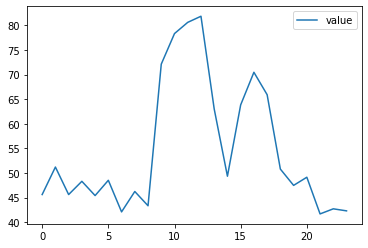

In [93]:
validation_df.plot()

In [94]:
prediction_df_p10 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p10'])
prediction_df_p10.head()

,Timestamp,Value
0,2014-11-01T00:00:00,38.109570
1,2014-11-01T01:00:00,32.248226
2,2014-11-01T02:00:00,29.114925
3,2014-11-01T03:00:00,20.245989
4,2014-11-01T04:00:00,15.206353


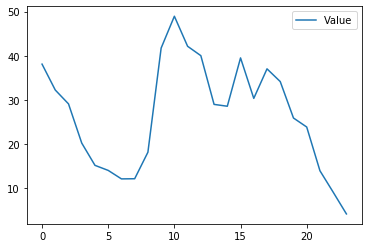

In [95]:
prediction_df_p10.plot()

In [96]:
prediction_df_p50 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p50'])
prediction_df_p90 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p90'])

In [97]:
results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])

In [98]:
for index, row in validation_df.iterrows():
    clean_timestamp = dt_parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['value'], 'source': 'actual'} , ignore_index=True)

In [99]:
results_df.head()

,timestamp,value,source
0,2014-11-01 00:00:00,45.605307,actual
1,2014-11-01 01:00:00,51.202322,actual
2,2014-11-01 02:00:00,45.605307,actual
3,2014-11-01 03:00:00,48.300166,actual
4,2014-11-01 04:00:00,45.398010,actual


In [100]:
for index, row in prediction_df_p10.iterrows():
    clean_timestamp = dt_parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in prediction_df_p50.iterrows():
    clean_timestamp = dt_parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in prediction_df_p90.iterrows():
    clean_timestamp = dt_parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

In [101]:
results_df

,timestamp,value,source
0,2014-11-01 00:00:00,45.605307,actual
1,2014-11-01 01:00:00,51.202322,actual
2,2014-11-01 02:00:00,45.605307,actual
3,2014-11-01 03:00:00,48.300166,actual
4,2014-11-01 04:00:00,45.398010,actual
...,...,...,...
91,2014-11-01 19:00:00,49.230274,p90
92,2014-11-01 20:00:00,48.036377,p90
93,2014-11-01 21:00:00,32.096226,p90
94,2014-11-01 22:00:00,25.110338,p90


In [102]:
pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")
pivot_df.head()

source,actual,p10,p50,p90
timestamp,,,,
2014-11-01 00:00:00,45.605307,38.109570,44.133854,49.089493
2014-11-01 01:00:00,51.202322,32.248226,37.378513,42.317074
2014-11-01 02:00:00,45.605307,29.114925,32.856689,38.097000
2014-11-01 03:00:00,48.300166,20.245989,24.009670,29.173306
2014-11-01 04:00:00,45.398010,15.206353,18.943827,23.354261


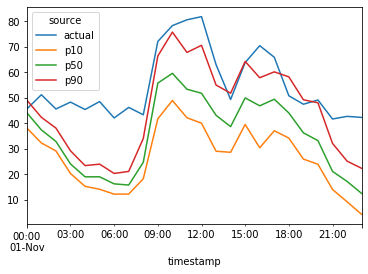

In [103]:
pivot_df.plot()